In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [101]:
predicted_yield = pd.read_csv('/Users/evelynli/Documents/Work/ASL/ETF Hedging Data/ETF/processed data/predicted_yields.csv', index_col= 'Date', parse_dates=True)
predicted_yield_change = pd.read_csv('/Users/evelynli/Documents/Work/ASL/ETF Hedging Data/ETF/processed data/predicted_yield_change.csv', index_col= 'Date', parse_dates=True)
etf_df = pd.read_csv('/Users/evelynli/Documents/Work/ASL/ETF Hedging Data/ETF/processed data/adjusted_nav.csv', index_col= 'Date', parse_dates=True)
etf_df = etf_df[['IEF', 'TLT', 'BIL', 'SGOV']]
future_df = pd.read_csv('/Users/evelynli/Documents/Work/ASL/ETF Hedging Data/Future prices/Future prices1.csv', index_col= 'Date', parse_dates=True)
yield_df = pd.read_csv('/Users/evelynli/Documents/Work/ASL/ETF Hedging Data/ETF/processed data/daily-treasury-rates.csv', index_col= 'Date', parse_dates=True)
etf_dv01 = pd.read_csv('/Users/evelynli/Documents/Work/ASL/ETF Hedging Data/ETF/processed data/ETF_DV01.csv', index_col= 'Date', parse_dates=True)
etf_dv01 = etf_dv01[['IEF', 'TLT', 'BIL', 'SGOV']]
future_dv01 = pd.read_excel('/Users/evelynli/Documents/Work/ASL/Duration Data/Futures duration.xlsx').transpose()
future_dv01.columns = future_dv01.iloc[0]
future_dv01 = future_dv01[1:]
future_dv01= future_dv01.astype(float)
etf_returns = etf_df.pct_change().dropna()
future_returns = future_df.pct_change().dropna()
etf_lag = etf_df.shift(1)
future_lag = future_df.shift(1)
etf_dv01_lag = etf_dv01.shift(1)

etf_name = ['IEF', 'TLT', 'BIL', 'SGOV']
std_devs = {'1': 0.074356, '3': 0.041143, '6': 0.041759, '12':0.058881, '24': 0.072617, '36': 0.074062, '60':0.073312, '84': 0.071730, '120': 0.066565, '240': 0.060877, '360': 0.059156}

In [102]:
predicted_signal = pd.read_csv('/Users/evelynli/Documents/Work/ASL/ETF Hedging Data/ETF/processed data/predicted_signals1.csv', index_col= 'Date', parse_dates=True)

In [103]:
test_dates = future_df.index.intersection(etf_dv01.index).intersection(etf_returns.index).intersection(future_returns.index).intersection(predicted_signal.index)
etf_dv01 = etf_dv01.loc[test_dates]
etf_returns = etf_returns.loc[test_dates]
future_returns = future_returns.loc[test_dates]
predicted_signal = predicted_signal.loc[test_dates]
etf_df = etf_df.loc[test_dates]
etf_lag = etf_lag.loc[test_dates]
future_lag = future_lag.loc[test_dates]
future_df = future_df.loc[test_dates]
#historical_signal = historical_signal.loc[test_dates]

In [104]:
market = pd.read_csv('/Users/evelynli/Documents/Work/ASL/Historical Data/LUATTRUU.csv', index_col= 'Date', parse_dates=True)
market = market['PX_LAST']
market = market.pct_change().dropna()
market = market.to_frame()
market = market.loc[test_dates]

In [105]:
log_future_returns = np.log(future_returns + 1)
log_etf_returns = np.log(etf_returns + 1)

In [106]:
# Process outliers

def rolling_outliers_sigma(df, column, window_size=10):
    rolling_df = df[column].rolling(window=window_size)
    
    def sigma_filter(subset):
        mean = subset.mean()
        std = subset.std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        
        return subset.apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan).mean()
    
    df[column] = rolling_df.apply(sigma_filter, raw=False)

    df[column] = df[column].ffill().bfill()
    
    return df




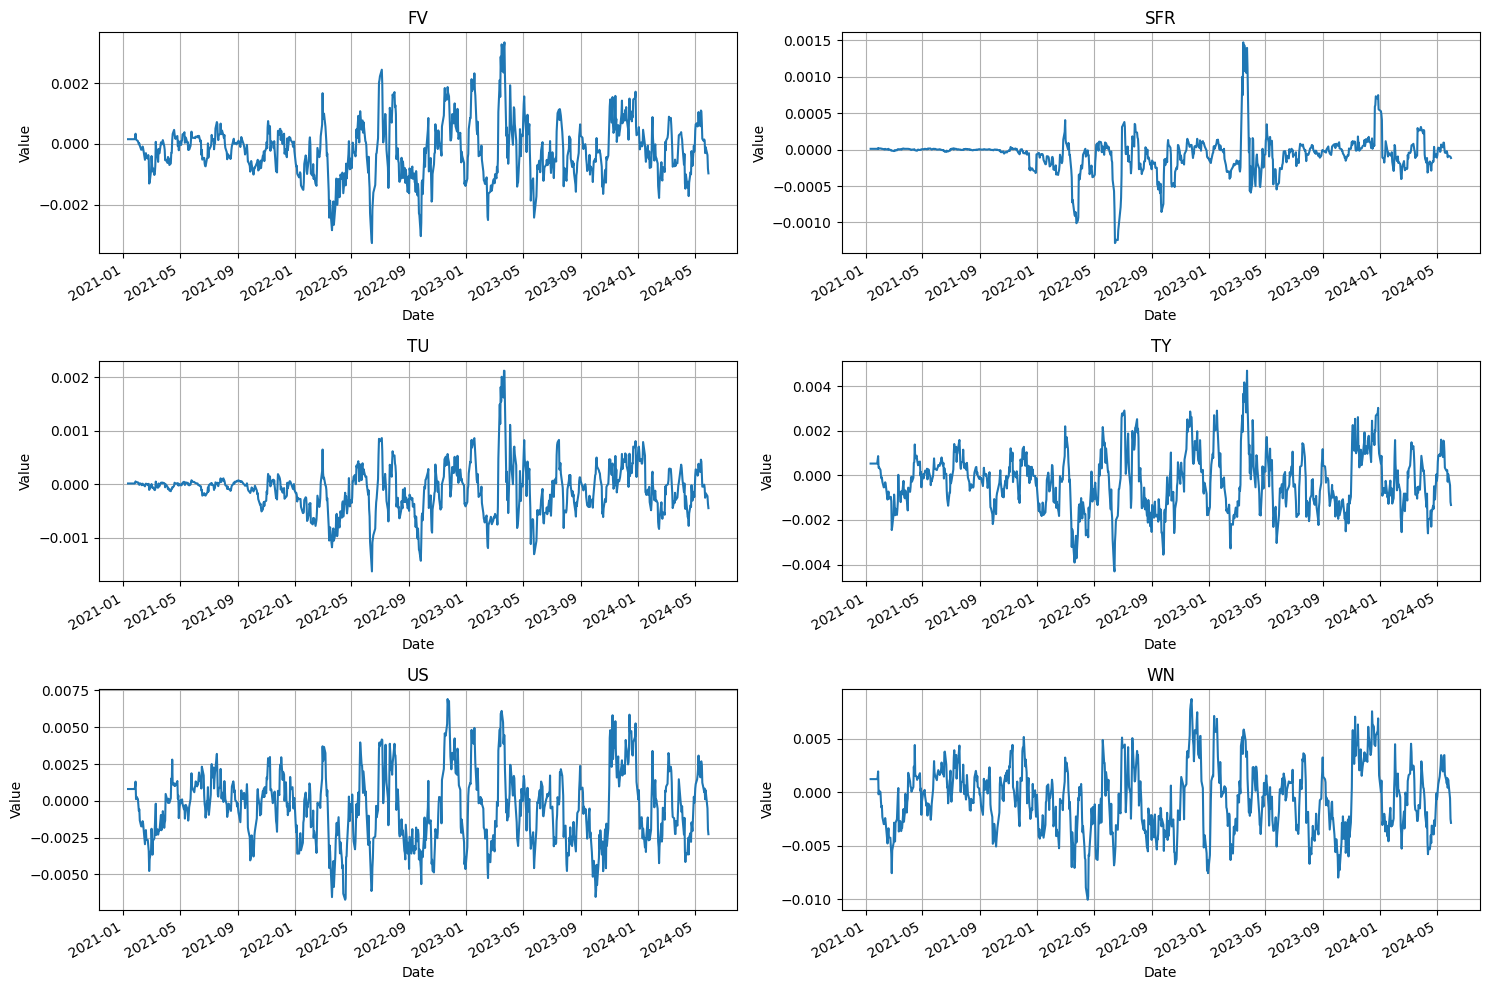

In [98]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()

# 遍历 data 的每一列，绘制折线图
for i, column in enumerate(future_returns.columns):
    ax = axes[i]
    future_returns[column].plot(ax=ax, kind='line', title=column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.grid(True)

# 删除多余的子图
for j in range(len(future_returns.columns), len(axes)):
    fig.delaxes(axes[j])

# 调整布局并显示图形
plt.tight_layout()
plt.show()

In [92]:
spread_ratio

{'IEF': 0.6463414634146342,
 'TLT': 0.36123348017621143,
 'BIL': 0.7142857142857143,
 'SGOV': 0.7142857142857143}

In [107]:
hedge_future_mapping = {'IEF': 'TY', 'TLT': 'WN', 'BIL': 'SFR', 'SGOV': 'SFR'}
duration_mapping = {'IEF': '84', 'TLT': '240', 'BIL': '3', 'SGOV': '3' }
spread_mapping = {'IEF': '120-60', 'TLT': '360-120', 'BIL': '24-3', 'SGOV': '24-3'}
spread_future_mapping = {'IEF': ['TY', 'FV'], 'TLT': ['WN', 'TY'], 'BIL': ['TU', 'SFR'], 'SGOV': ['TU', 'SFR']}
etf_multiplier = {'IEF': 1000, 'TLT': 1000, 'BIL': 100000, 'SGOV': 100000}
hedge_future_multiplier = {'TU':2000, 'FV': 1000, 'TY': 1000, 'US': 1000, 'WN': 1000, 'SFR': 2500}
transaction_cost_mapping = {'TU': 2 * 0.65, 'FV': 2 * 0.65, 'TY': 2 * 0.65, 'US': 2 * 0.87, 'WN': 2 * 0.95, 'SFR': 2 * 1.25}


In [108]:
def cal_hedge_ratio(etf_dv01, future_dv01, hedge_future_mapping, hedge_future_multiplier):
    hedge_ratio = pd.DataFrame(index = etf_dv01.index, columns = etf_dv01.columns)
    for etf in etf_dv01.columns:
        hedge_future = hedge_future_mapping[etf]
        dv01_f = float(future_dv01[hedge_future].item()) 
        hedge_ratio[etf] = etf_dv01[etf] / dv01_f
    return hedge_ratio

def cal_spread_ratio(future_dv01, spread_future_mapping, hedge_future_multiplier):
    etf_name = ['IEF', 'TLT', 'BIL', 'SGOV']
    spread_ratio = {}
    for etf in etf_name:
        dv01_f1 = float(future_dv01[spread_future_mapping[etf][0]].item())
        dv01_f2 = float(future_dv01[spread_future_mapping[etf][1]].item())
        spread_ratio[etf] = dv01_f2 / dv01_f1
    return spread_ratio

hedge_ratio = cal_hedge_ratio(etf_dv01, future_dv01, hedge_future_mapping, hedge_future_multiplier)
spread_ratio = cal_spread_ratio(future_dv01, spread_future_mapping, hedge_future_multiplier)

In [109]:
def cal_hedge_returns(predicted_signal, future_returns, future_lag, etf_returns, etf_lag, duration_mapping, hedge_future_mapping, hedge_ratio, hedge_future_multiplier, transaction_cost_mapping, AR):
    hedge_returns = pd.DataFrame(index = predicted_signal.index, columns = etf_name)
    for etf in etf_returns.columns:
        signal = duration_mapping[etf]
        hedge_future = hedge_future_mapping[etf]
        multiplier = hedge_future_multiplier[hedge_future]
        cost = transaction_cost_mapping[hedge_future]
        #initial_value = etf_lag[etf] + AR * hedge_ratio[etf] * multiplier * future_lag[hedge_future]
        #returns = (etf_df[etf] - etf_lag[etf]) - predicted_signal[signal] * AR * hedge_ratio[etf] * multiplier * (future_df[hedge_future] - future_lag[hedge_future]) - AR * hedge_ratio[etf] * cost
        #hedge_returns[etf] = returns / initial_value
        hedge_returns[etf] = etf_returns[etf] - predicted_signal[signal] * AR * hedge_ratio[etf] * multiplier * future_returns[hedge_future] - AR * hedge_ratio[etf] * cost/ future_lag[hedge_future]
    log_hedge_returns = np.log(hedge_returns + 1)
    for etf in log_hedge_returns.columns:
        log_hedge_returns = rolling_outliers_sigma(log_hedge_returns, etf)
        hedge_returns = np.exp(log_hedge_returns) - 1
    return hedge_returns

hedge_returns= cal_hedge_returns(predicted_signal, future_returns, future_lag, etf_returns, etf_lag, duration_mapping, hedge_future_mapping, hedge_ratio, hedge_future_multiplier, transaction_cost_mapping, 1/4)

In [100]:
hedge_returns

,IEF,TLT,BIL,SGOV
Date,,,,
2021-01-11,0.000664,0.001431,-0.000002,0.000004
2021-01-12,0.000664,0.001431,-0.000002,0.000004
2021-01-13,0.000664,0.001431,-0.000002,0.000004
2021-01-14,0.000664,0.001431,-0.000002,0.000004
2021-01-15,0.000664,0.001431,-0.000002,0.000004
...,...,...,...,...
2024-05-23,0.001062,0.002087,0.000198,0.000206
2024-05-24,0.000979,0.002036,0.000203,0.000207
2024-05-28,0.000832,0.001797,0.000204,0.000209


In [110]:
def cal_spread_returns(predicted_signal, future_returns, future_lag, spread_mapping, spread_future_mapping, spread_ratio, hedge_future_multiplier, transaction_cost_mapping):
    spread_returns = pd.DataFrame(index = predicted_signal.index, columns = etf_name)
    for etf in spread_mapping.keys():
        signal = spread_mapping[etf]
        future_l = spread_future_mapping[etf][0]
        future_s = spread_future_mapping[etf][1]
        multiplier_l = hedge_future_multiplier[future_l]
        multiplier_s = hedge_future_multiplier[future_s]
        cost_l = transaction_cost_mapping[future_l]
        cost_s = transaction_cost_mapping[future_s]
        #initial_value = multiplier_s * future_lag[future_s] + spread_ratio[etf] * multiplier_l * future_lag[future_l]
        #returns = predicted_signal[signal] * (multiplier_s * (future_df[future_s] - future_lag[future_s]) - spread_ratio[etf] * multiplier_l * (future_df[future_l] - future_lag[future_l])) - (cost_s + spread_ratio[etf] * cost_l)
        #spread_returns[etf] = returns / initial_value
        spread_returns[etf] = predicted_signal[signal] * (future_returns[future_s] - spread_ratio[etf] *( multiplier_l / multiplier_s) * future_returns[future_l]) - (spread_ratio[etf] * multiplier_l / multiplier_s) * cost_l / (multiplier_l * future_lag[future_l]) - cost_s / (multiplier_s * future_lag[future_s])
    
    log_spread_returns = np.log(spread_returns + 1)
    for etf in log_spread_returns.columns:
        log_spread_returns = rolling_outliers_sigma(log_spread_returns, etf)
        spread_returns = np.exp(log_spread_returns) - 1
    return spread_returns

spread_returns = cal_spread_returns(predicted_signal, future_returns, future_lag, spread_mapping, spread_future_mapping, spread_ratio, hedge_future_multiplier, transaction_cost_mapping)
spread_returns

,IEF,TLT,BIL,SGOV
Date,,,,
2021-01-11,0.000328,0.000847,0.000005,0.000005
2021-01-12,0.000328,0.000847,0.000005,0.000005
2021-01-13,0.000328,0.000847,0.000005,0.000005
2021-01-14,0.000328,0.000847,0.000005,0.000005
2021-01-15,0.000328,0.000847,0.000005,0.000005
...,...,...,...,...
2024-05-23,0.000203,0.000551,0.000241,0.000241
2024-05-24,0.000235,0.000418,0.000212,0.000212
2024-05-28,0.000274,0.000546,0.000190,0.000190


In [111]:
def objective(params, etf, window_signal, window_future_returns, window_future_lag, window_etf_returns, window_etf_lag, 
              duration_mapping, hedge_future_mapping, hedge_future_multiplier, transaction_cost_mapping, 
              spread_mapping, spread_future_mapping, spread_ratio, market):
    a, AR = params  
    # Calculate Hedge Returns and Spread Returns
    hedge_returns = cal_hedge_returns(window_signal, window_future_returns, window_future_lag, window_etf_returns, 
                                      window_etf_lag, duration_mapping, hedge_future_mapping, hedge_ratio, 
                                      hedge_future_multiplier, transaction_cost_mapping, AR)[etf]
    spread_returns = cal_spread_returns(window_signal, window_future_returns, window_future_lag, spread_mapping, 
                                        spread_future_mapping, spread_ratio, hedge_future_multiplier, 
                                        transaction_cost_mapping)[etf]
    # Calculate Portfolio Returns
    Rp = (a * hedge_returns + (1 - a) * spread_returns).sub(market['PX_LAST'], axis=0)
    annual_factor = np.sqrt(252)
    sharpe_ratio = (np.mean(Rp) * 252) / (np.std(Rp) * annual_factor) if np.std(Rp) > 0 else -np.inf
    return -sharpe_ratio 

In [112]:
optimization_results = {etf: [] for etf in etf_df.columns}
window_size = 60 

for etf in etf_df.columns:
    # Optimization Loop
    for i in range(window_size, len(predicted_signal)):
        window_signal = predicted_signal.iloc[i - window_size:i]
        window_future_returns = future_returns.iloc[i - window_size:i]
        window_future_lag = future_lag.iloc[i - window_size:i]
        window_etf_returns = etf_returns.iloc[i - window_size:i]
        window_etf_lag = etf_lag.iloc[i - window_size:i]
        window_market = market.iloc[i - window_size:i]
        
        # 检查数据是否包含 NaN 或 inf
        if window_signal.isnull().values.any() or window_future_returns.isnull().values.any() or \
           window_future_lag.isnull().values.any() or window_etf_returns.isnull().values.any() or \
           window_etf_lag.isnull().values.any() or window_market.isnull().values.any():
            print(f"Skipping optimization for {etf} on {predicted_signal.index[i]} due to NaN values.")
            continue

        if np.isinf(window_signal.values).any() or np.isinf(window_future_returns.values).any() or \
           np.isinf(window_future_lag.values).any() or np.isinf(window_etf_returns.values).any() or \
           np.isinf(window_etf_lag.values).any() or np.isinf(window_market.values).any():
            print(f"Skipping optimization for {etf} on {predicted_signal.index[i]} due to inf values.")
            continue
                
        # 初始猜测参数 [a, AR]
        initial_guess = [0.5, 0.5]

        # 执行优化过程
        result = minimize(
            objective,
            initial_guess,
            args=(etf, window_signal, window_future_returns, window_future_lag, window_etf_returns, window_etf_lag, 
                  duration_mapping, hedge_future_mapping, hedge_future_multiplier, transaction_cost_mapping, 
                  spread_mapping, spread_future_mapping, spread_ratio, window_market),
            bounds=[(0.5, 1), (1/10, 3/4)],
            method='L-BFGS-B'
        )

        # 提取优化结果
        optimal_a = result.x[0]
        optimal_AR = result.x[1]
        max_sharpe = -result.fun

        # 存储优化结果
        optimization_results[etf].append({
            'Date': predicted_signal.index[i],
            'Optimal_a': optimal_a,
            'Optimal_AR': optimal_AR,
            'Max_Sharpe': max_sharpe
        })

# 将结果转换为 DataFrame，便于后续分析和使用
optimization_results_df = {etf: pd.DataFrame(results) for etf, results in optimization_results.items()}

# 输出每个 ETF 的最新优化结果
for etf, results_df in optimization_results_df.items():
    latest_result = results_df.iloc[-1]
    print(f"ETF: {etf}")
    print(f"Optimal a for today: {latest_result['Optimal_a']}")
    print(f"Optimal AR for today: {latest_result['Optimal_AR']}")
    print(f"Maximum Sharpe Ratio: {latest_result['Max_Sharpe']}")
    print()

ETF: IEF
Optimal a for today: 1.0
Optimal AR for today: 0.75
Maximum Sharpe Ratio: 6.096862492870027

ETF: TLT
Optimal a for today: 1.0
Optimal AR for today: 0.75
Maximum Sharpe Ratio: 10.178628388919021

ETF: BIL
Optimal a for today: 1.0
Optimal AR for today: 0.75
Maximum Sharpe Ratio: 0.9722732280874503

ETF: SGOV
Optimal a for today: 1.0
Optimal AR for today: 0.75
Maximum Sharpe Ratio: 0.9847649199622066



In [115]:
optimal_AR_df = pd.DataFrame()
optimal_a_df = pd.DataFrame()
for etf in etf_returns.columns:
    optimal_df = optimization_results_df[etf].set_index('Date')
    optimal_a_df[etf] = optimal_df['Optimal_a']
    optimal_AR_df[etf] = optimal_df['Optimal_AR']


In [117]:
optimized_daily_returns = pd.DataFrame(index=hedge_returns.index, columns=etf_df.columns)

def cal_optimized_hedge_ret(predicted_signal, future_df, future_lag, etf_df, etf_lag, duration_mapping, hedge_future_mapping, hedge_ratio, hedge_future_multiplier, transaction_cost_mapping, optimal_AR_df):
    optimal_hedge_returns = pd.DataFrame(index = predicted_signal.index, columns = etf_df.columns)
    PnL = pd.DataFrame(index = predicted_signal.index, columns = etf_name)
    for etf in etf_returns.columns:
        signal = duration_mapping[etf]
        hedge_future = hedge_future_mapping[etf]
        multiplier = hedge_future_multiplier[hedge_future]
        cost = transaction_cost_mapping[hedge_future]
        #initial_value = etf_lag[etf] + optimal_AR_df[etf] * hedge_ratio[etf] * multiplier * future_lag[hedge_future]
        #returns = (etf_df[etf] - etf_lag[etf]) - predicted_signal[signal] * optimal_AR_df[etf] * hedge_ratio[etf] * multiplier * (future_df[hedge_future] - future_lag[hedge_future]) - optimal_AR_df[etf] * hedge_ratio[etf] * cost
        #PnL[etf] = returns
        #hedge_returns[etf] = returns / initial_value
        hedge_returns[etf] = (etf_df[etf] / etf_lag[etf] - 1) - predicted_signal[signal] * optimal_AR_df[etf] * hedge_ratio[etf] * multiplier * (future_df[hedge_future] / future_lag[hedge_future] - 1) - optimal_AR_df[etf] * hedge_ratio[etf] * cost / (future_lag[hedge_future] * multiplier)
    return hedge_returns

optimized_hedge_returns = cal_optimized_hedge_ret(predicted_signal, future_df, future_lag, etf_df, etf_lag, duration_mapping, hedge_future_mapping, hedge_ratio, hedge_future_multiplier, transaction_cost_mapping, optimal_AR_df)

In [118]:
def cal_optimized_port_ret(optimized_hedge_returns, spread_returns, optimal_a_df):
    optimized_port_returns = pd.DataFrame(index = predicted_signal.index, columns = etf_name)
    for etf in etf_name:
        optimized_port_returns[etf] = optimized_hedge_returns[etf] + (1 - optimal_a_df[etf])/optimal_a_df[etf] * spread_returns[etf]
    return optimized_port_returns

optimized_port_returns = cal_optimized_port_ret(optimized_hedge_returns, spread_returns, optimal_a_df)
optimized_port_returns

,IEF,TLT,BIL,SGOV
Date,,,,
2021-01-11,NaN,NaN,NaN,NaN
2021-01-12,NaN,NaN,NaN,NaN
2021-01-13,NaN,NaN,NaN,NaN
2021-01-14,NaN,NaN,NaN,NaN
2021-01-15,NaN,NaN,NaN,NaN
...,...,...,...,...
2024-05-23,-0.002209,-0.004004,1.596183e-04,0.000162
2024-05-24,0.001029,0.002768,5.667971e-04,0.000577
2024-05-28,-0.002695,-0.007237,1.373413e-04,0.000140


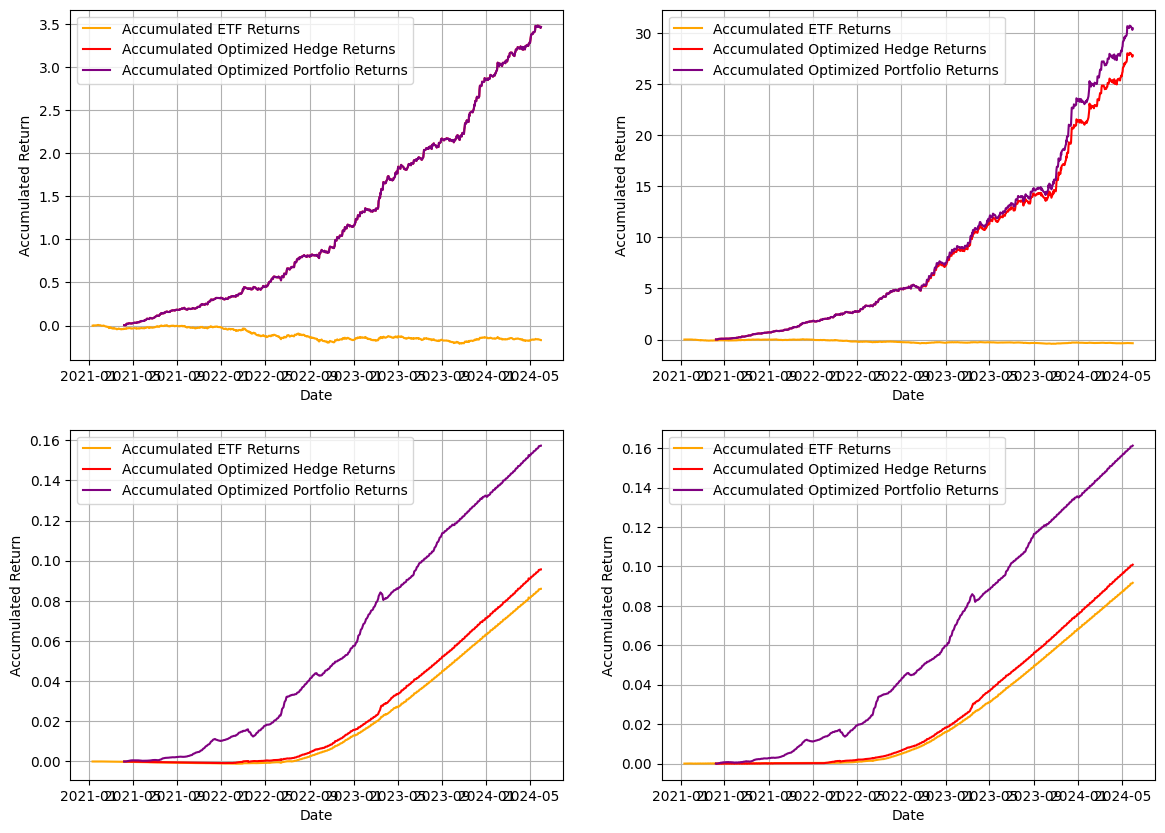

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 hedge_returns 和 etf_returns 是 pandas DataFrame
# hedge_returns = pd.read_csv('path_to_hedge_returns.csv')  # 如果需要从文件加载数据
# etf_returns = pd.read_csv('path_to_etf_returns.csv')  # 如果需要从文件加载数据

# 确保 hedge_returns 和 etf_returns 有相同的列
#assert hedge_returns.columns.equals(etf_returns.columns), "hedge_returns 和 etf_returns 的列不匹配"

# 计算累计收益
#   accumulated_hedge_returns = (1 + hedge_returns).cumprod() - 1
accumulated_etf_returns = (1 + etf_returns).cumprod() - 1
#   excess_return = pd.DataFrame(index = etf_returns.index, columns = etf_returns.columns)
#   for etf in etf_returns.columns:
    #   excess_return[etf] = hedge_returns[etf] - etf_returns[etf]
#   accumulated_excess_returns = (1 + excess_return).cumprod() - 1
accu_optimized_hedge_returns = (1 + optimized_hedge_returns).cumprod() - 1
accu_optimized_port_returns = (1 + optimized_port_returns).cumprod() - 1
#accu_optimized_port_returns_no_outliers = (1 + optimized_port_returns_no_outliers).cumprod() - 1

#accumulated_hedge_returns

# 创建包含四个子图的图形
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 绘制每列的累计收益比较图
for i, column in enumerate(hedge_returns.columns):
    ax = axes[i]
    #ax.plot(accumulated_hedge_returns.index, accumulated_hedge_returns[column], label='Accumulated Hedge Returns', color='blue')
    ax.plot(accumulated_etf_returns.index, accumulated_etf_returns[column], label='Accumulated ETF Returns', color='orange')
    #ax.plot(accumulated_excess_returns.index, accumulated_excess_returns[column], label='Accumulated Excess Returns', color='green')
    ax.plot(accu_optimized_hedge_returns.index, accu_optimized_hedge_returns[column], label='Accumulated Optimized Hedge Returns', color='red')
    ax.plot(accu_optimized_port_returns.index, accu_optimized_port_returns[column], label='Accumulated Optimized Portfolio Returns', color='purple')
    #ax.plot(accu_optimized_port_returns_no_outliers.index, accu_optimized_port_returns_no_outliers[column], label='Accumulated Optimized Portfolio Returns without Outliers', color = 'black')
    ax.set_xlabel('Date')
    ax.set_ylabel('Accumulated Return')
    ax.legend()
    ax.grid(True)

# 调整布局并显示图形
#plt.tight_layout()
plt.show()

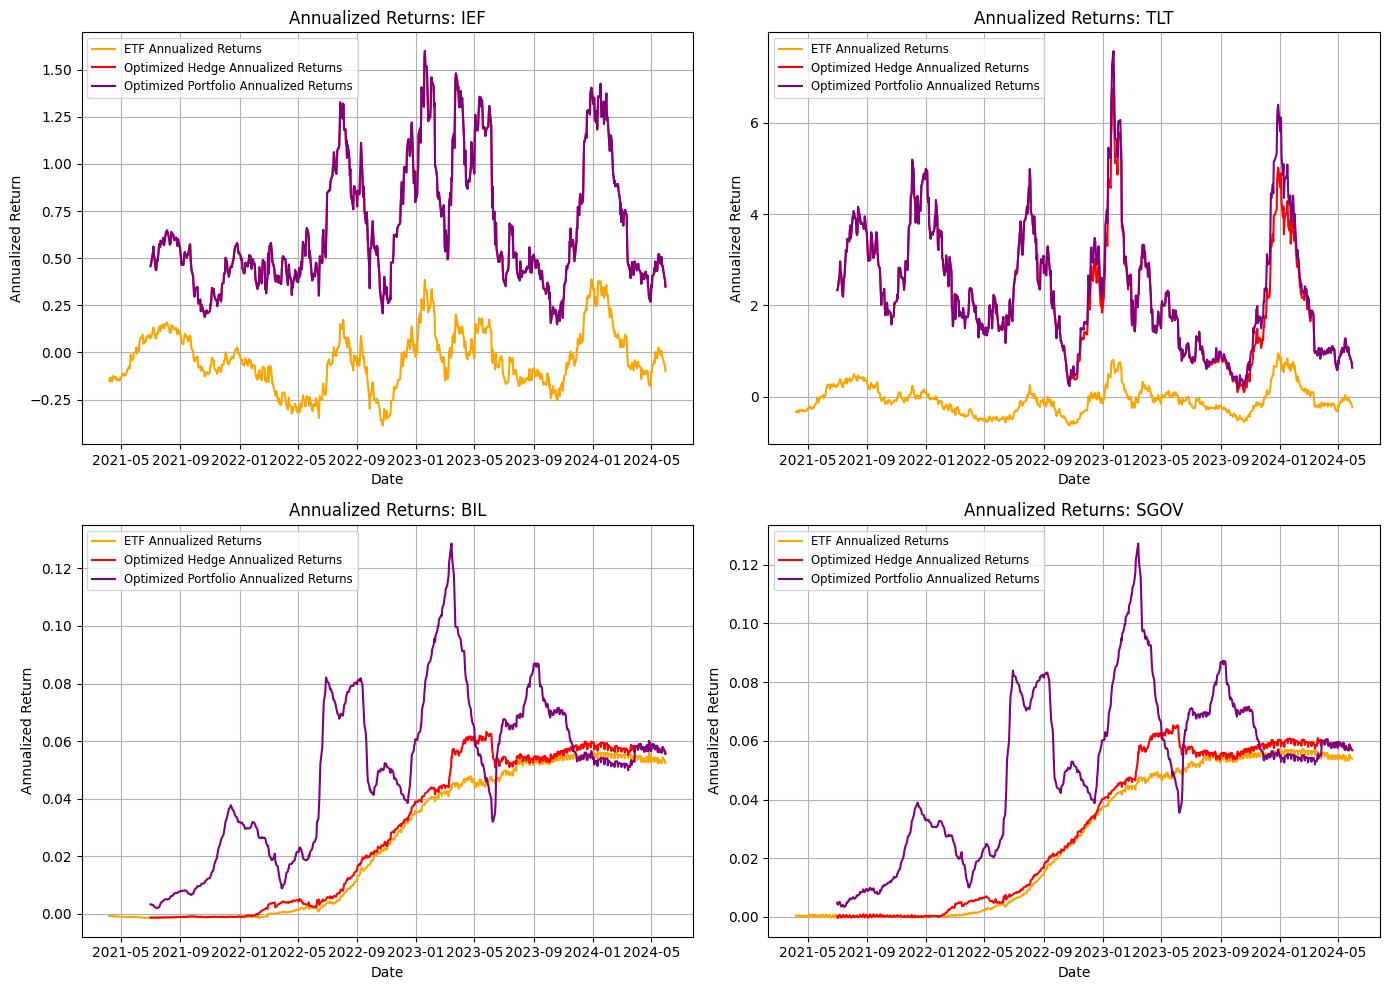

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# 定义年化收益率计算函数
def calculate_annualized_return(returns, window=60):
    return (1 + returns.rolling(window).apply(lambda x: (x + 1).prod() - 1, raw=False)) ** (252 / window) - 1

# 计算滚动年化收益率
annualized_etf_returns = calculate_annualized_return(etf_returns)
annualized_hedge_returns = calculate_annualized_return(optimized_hedge_returns)
annualized_port_returns = calculate_annualized_return(optimized_port_returns)
#annualized_port_returns_no_outliers = calculate_annualized_return(optimized_port_returns_no_outliers)

# 创建包含四个子图的图形
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 绘制每列的年化收益率变化图
for i, column in enumerate(etf_returns.columns):
    ax = axes[i]
    ax.plot(annualized_etf_returns.index, annualized_etf_returns[column], label='ETF Annualized Returns', color='orange')
    ax.plot(annualized_hedge_returns.index, annualized_hedge_returns[column], label='Optimized Hedge Annualized Returns', color='red')
    ax.plot(annualized_port_returns.index, annualized_port_returns[column], label='Optimized Portfolio Annualized Returns', color='purple')
    #ax.plot(annualized_port_returns_no_outliers.index, annualized_port_returns_no_outliers[column], label='Portfolio Returns without Outliers', color='black')
    
    # 设置标签和图例
    ax.set_xlabel('Date')
    ax.set_ylabel('Annualized Return')
    ax.legend(loc='upper left', fontsize='small')
    ax.grid(True)
    ax.set_title(f'Annualized Returns: {column}')

# 调整布局使子图不重叠，并显示图形
plt.tight_layout()
plt.show()


In [122]:
#   excess_returns_optimized = optimized_port_returns_no_outliers.sub(market['PX_LAST'], axis=0)
excess_returns_optimized = optimized_port_returns.sub(market['PX_LAST'], axis=0)
excess_returns_etf = etf_returns.sub(market['PX_LAST'], axis=0)

mean_excess_return_optimized = excess_returns_optimized.mean()
std_excess_return_optimized = excess_returns_optimized.std()
mean_excess_return_etf = excess_returns_etf.mean()
std_excess_return_etf = excess_returns_etf.std()

# 年化系数（假设每日数据，252个交易日）
annual_factor = np.sqrt(252)

# 计算优化组合和单纯持有 ETF 的 Sharpe Ratio
#sharpe_ratio_optimized = (mean_excess_return_optimized * 252) / (std_excess_return_optimized * annual_factor)
#sharpe_ratio_etf = (mean_excess_return_etf * 252) / (std_excess_return_etf * annual_factor)

sharpe_ratio_optimized = (mean_excess_return_optimized/ std_excess_return_optimized) * annual_factor
sharpe_ratio_etf = (mean_excess_return_etf/ std_excess_return_etf) * annual_factor

print("Sharpe Ratio (Annualized, Excess Return) of Each ETF - Optimized Portfolio:")
print(sharpe_ratio_optimized)
print("\nSharpe Ratio (Annualized, Excess Return) of Each ETF - Holding ETF:")
print(sharpe_ratio_etf)

Sharpe Ratio (Annualized, Excess Return) of Each ETF - Optimized Portfolio:
IEF     4.127675
TLT     5.587983
BIL     0.320036
SGOV    0.337530
dtype: float64

Sharpe Ratio (Annualized, Excess Return) of Each ETF - Holding ETF:
IEF    -0.833962
TLT    -0.851503
BIL    -0.131654
SGOV   -0.106286
dtype: float64



Maximum Drawdown of Each ETF - Optimized Portfolio:
IEF    -0.028577
TLT    -0.088232
BIL    -0.003533
SGOV   -0.003600
dtype: float64

Maximum Drawdown of Each ETF - Holding ETF:
IEF    -0.217890
TLT    -0.437206
BIL    -0.001163
SGOV   -0.000152
dtype: float64


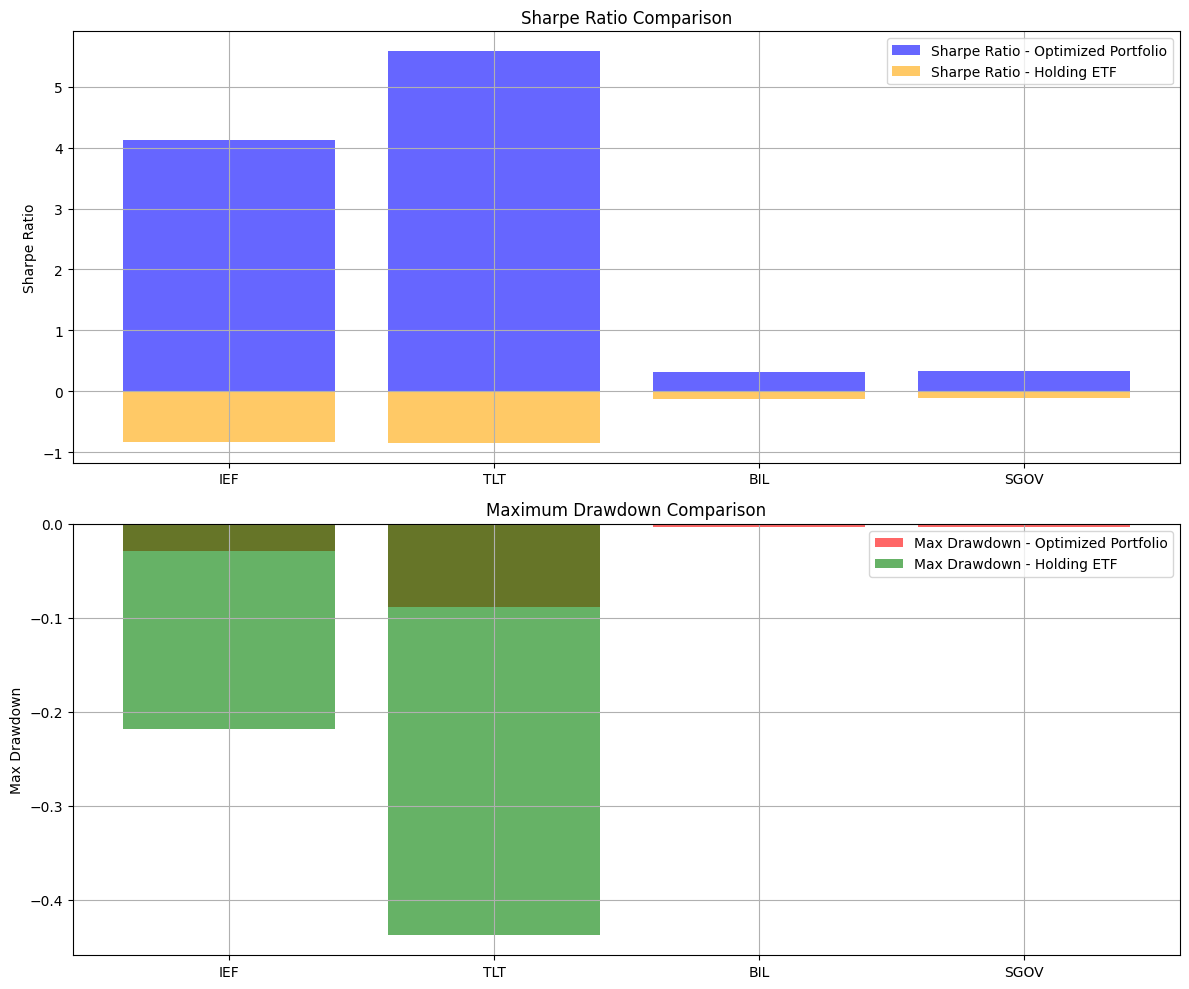

In [123]:
def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_dd = drawdown.min()
    return max_dd

# 计算每个 ETF 的最大回撤
max_drawdowns_optimized = optimized_port_returns.apply(max_drawdown)
max_drawdowns_etf = etf_returns.apply(max_drawdown)

print("\nMaximum Drawdown of Each ETF - Optimized Portfolio:")
print(max_drawdowns_optimized)
print("\nMaximum Drawdown of Each ETF - Holding ETF:")
print(max_drawdowns_etf)

# 可视化对比结果
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Sharpe Ratio 对比
axes[0].bar(sharpe_ratio_optimized.index, sharpe_ratio_optimized, color='blue', alpha=0.6, label='Sharpe Ratio - Optimized Portfolio')
axes[0].bar(sharpe_ratio_etf.index, sharpe_ratio_etf, color='orange', alpha=0.6, label='Sharpe Ratio - Holding ETF')
axes[0].set_ylabel('Sharpe Ratio')
axes[0].set_title('Sharpe Ratio Comparison')
axes[0].grid(True)
axes[0].legend()

# 最大回撤对比
axes[1].bar(max_drawdowns_optimized.index, max_drawdowns_optimized, color='red', alpha=0.6, label='Max Drawdown - Optimized Portfolio')
axes[1].bar(max_drawdowns_etf.index, max_drawdowns_etf, color='green', alpha=0.6, label='Max Drawdown - Holding ETF')
axes[1].set_ylabel('Max Drawdown')
axes[1].set_title('Maximum Drawdown Comparison')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()